In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, pipeline, AutoModelForSeq2SeqLM
from transformers import BartConfig
import pandas as pd
import numpy as np
from sklearn import metrics
import torch
import torch.nn.functional as F
import pickle
from datasets import load_dataset
import matplotlib.pyplot as plt
import pickle
import scipy
from tqdm import tqdm
import shap

from utils import *

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients, InputXGradient

from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

from sentence_transformers import SentenceTransformer, util

model_name = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sent_model = SentenceTransformer('all-MiniLM-L6-v2')

import pickle
fname = 'samples-test'

text_exp = pickle.load(open('explanations-all-main.pkl', 'rb'))

# Model Wrapper 
class ModelWrap:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def encode(self, x):
        with torch.no_grad():
            inputs = tokenizer(
                x, 
                return_tensors='pt', 
                padding=True, 
                truncation=True, 
                max_length=512
            )
            rep = model.model(**inputs).last_hidden_state
            assert(rep.shape[0] == len(x))
        return rep.mean(dim=1).cpu().detach().numpy()

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
bart_model = ModelWrap(model, tokenizer)

## Evaluating highlight among methods

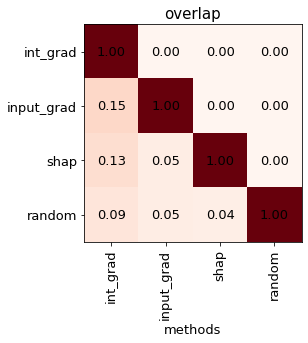

In [40]:
# evaluate sentence overlap among the methods using IOU metric (among the post hoc)
methods = ['int_grad', 'input_grad', 'shap', 'random']

def compute_jaccard_dist(attr1, attr2):
    if len(attr1) != len(attr2):
        if len(attr1) < len(attr2):
            attr2 = attr2[:len(attr1)]
        else:
            attr1 = attr1[:len(attr2)]
    assert(len(attr1) == len(attr2))
    s = attr1 + attr2
    both = np.where(s == 2)[0].shape[0]
    picked = np.where(s > 0)[0].shape[0]
    return both / picked

def overlap_scale(top_k):
    # compute the scale (interpretation)
    pass

def binarize(attr):
    return np.where(attr>0, 1, 0)

def sent2bin(sent_ids, top_k=3):
    out = np.zeros(len(sent_ids))
    out[sent_ids[:top_k]] = 1
    return out

# highlight based on sentence
overlap_results = dict()
top_k=2
for idx in text_exp.keys():
    corr_mat = np.zeros((len(methods), len(methods)))
    wrong_mat = [np.zeros((len(methods), len(methods))) for _ in range(len(text_exp[idx]['random_attr_sent_viz']['wrong']))]
    for i in range(len(methods)):
        for j in range(i, len(methods)):
            m1 = methods[i]
            m2 = methods[j]
            if m1 == 'pairs' and m2 != 'pairs':
                word_attr_correct = binarize(pairs_results[idx][0])
                word_attr_wrong = [binarize(x) for x in pairs_results[idx][1:]]
                word_attr_correct2 = sent2bin(text_exp[idx]['%s_attr_sent'%m2]['correct'][2], top_k=top_k)
                word_attr_wrong2 = [sent2bin(t[2], top_k=top_k) for t in text_exp[idx]['%s_attr_sent'%m2]['wrong']]
            elif m2 == 'pairs' and m1 != 'pairs':
                word_attr_correct = sent2bin(text_exp[idx]['%s_attr_sent'%m1]['correct'][2], top_k=top_k)
                word_attr_wrong = [sent2bin(t[2], top_k=top_k) for t in text_exp[idx]['%s_attr_sent'%m1]['wrong']]
                word_attr_correct2 = binarize(pairs_results[idx][0])
                word_attr_wrong2 = [binarize(x) for x in pairs_results[idx][1:]]
            elif m1 == 'pairs' and m2 == 'pairs':
                word_attr_correct = binarize(pairs_results[idx][0])
                word_attr_wrong = [binarize(x) for x in pairs_results[idx][1:]]
                word_attr_correct2 = binarize(pairs_results[idx][0])
                word_attr_wrong2 = [binarize(x) for x in pairs_results[idx][1:]]
            else:
                word_attr_correct = sent2bin(text_exp[idx]['%s_attr_sent'%m1]['correct'][2], top_k=top_k)
                word_attr_wrong = [sent2bin(t[2], top_k=top_k) for t in text_exp[idx]['%s_attr_sent'%m1]['wrong']]
                word_attr_correct2 = sent2bin(text_exp[idx]['%s_attr_sent'%m2]['correct'][2], top_k=top_k)
                word_attr_wrong2 = [sent2bin(t[2], top_k=top_k) for t in text_exp[idx]['%s_attr_sent'%m2]['wrong']]

            try:
                corr_mat[j,i] = compute_jaccard_dist(word_attr_correct, word_attr_correct2)
                for k in range(len(word_attr_wrong)):
                    wrong_mat[k][j,i] = compute_jaccard_dist(word_attr_wrong[k], word_attr_wrong[k])
            except ZeroDivisionError:
                print(idx, m1, m2)
                break
    overlap_results[idx] = [corr_mat] + wrong_mat

avg_mat = 0
for k in overlap_results.keys():
    avg_mat += overlap_results[k][0]
    #avg_mat += overlap_results[k][1]
    #avg_mat += overlap_results[k][2]
avg_mat /= (len(overlap_results))    

def plot_overlap(avg_mat,methods, title='overlap'):
    plt.imshow(avg_mat, cmap='Reds')
    plt.xlabel('methods', fontsize=13)
    plt.xticks(ticks=range(len(methods)), labels=methods, rotation=90, fontsize=13)
    plt.yticks(ticks=range(len(methods)), labels=methods, rotation=0, fontsize=13)
    # Loop over data dimensions and create text annotations.
    for i in range(len(methods)):
        for j in range(len(methods)):
            text = plt.text(j, i, '%0.2f'%avg_mat[i, j],
                           ha="center", va="center", color="k", fontsize=13)
    plt.title(title, fontsize=15)
plot_overlap(avg_mat, methods)

[[0.         0.         0.         0.        ]
 [0.01744719 0.         0.         0.        ]
 [0.01492341 0.02589278 0.         0.        ]
 [0.01667069 0.01669921 0.02125648 0.        ]]


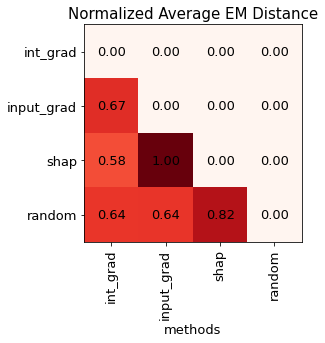

In [42]:
# EM distance
def get_random_attr(inp, thr=0.2):
    output = np.zeros(inp.shape)
    for i in range(len(output)):
        if np.random.random() < thr:
            output[i] = np.random.random() * 2 - 1
    output = output / np.linalg.norm(output)
    return output

methods = ['int_grad', 'input_grad', 'shap', 'random']
em_distance = dict()
for k in text_exp.keys():
    corr_mat = np.zeros((len(methods), len(methods)))
    wrong_mat = [np.zeros((len(methods), len(methods))) for _ in range(len(text_exp[26]['random_attr_sent_viz']['wrong']))]
    for i in range(len(methods)):
        for j in range(i, len(methods)):
            d12 = 0
            for _ in range(50):
                m1 = methods[i]
                m2 = methods[j]
                p1 = text_exp[k]['%s_attr_word'%m1]['correct'][0][1]
                p2 = text_exp[k]['%s_attr_word'%m2]['correct'][0][1]
                p1_w = [scipy.special.softmax(text_exp[k]['%s_attr_word'%m1]['wrong'][t][1]) for t in range(2)]
                p2_w = [scipy.special.softmax(text_exp[k]['%s_attr_word'%m2]['wrong'][t][1]) for t in range(2)]
                if m1 == 'random' and m2 != 'random':
                    p1 = get_random_attr(p1, thr=0.25)
                elif m2 == 'random' and m1 != 'random':
                    p2 = get_random_attr(p2, thr=0.25)
                elif m1 == 'random' and m2 == 'random':
                    p1 = get_random_attr(p1, thr=0.25)
                    p2 = p1
                d12 += scipy.stats.wasserstein_distance(p1, p2)
                d12_w = [scipy.stats.wasserstein_distance(pp1, pp2) for pp1, pp2 in zip(p1_w, p2_w)]
            
            corr_mat[j,i] = d12 / 50
            for l in range(2):
                wrong_mat[l][j,i] = d12_w[l]
    em_distance[k] = [corr_mat] + wrong_mat
    
avg_mat = 0
for k in em_distance.keys():
    avg_mat += em_distance[k][0]

avg_mat /= (len(em_distance)) 
print(avg_mat)
#normalize the distance
avg_mat = (avg_mat - np.min(avg_mat)) / (np.max(avg_mat) - np.min(avg_mat))
plot_overlap(avg_mat, methods, title='Normalized Average EM Distance')
plt.savefig('emdist.pdf', dpi=200, bbox_inches='tight')

## ROUGE-metric evaluation

In [11]:
from rouge_score import rouge_scorer

# compute ROUGE value based on information extracted
def compute_rouge_attr_vs_summary(sents, sent_idx, target_text, top_k=3):
    selected_text = '\n'.join([sents[i] for i in sent_idx[:top_k]])
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(selected_text, target_text)
    return scores

# compute ROUGE for pairs-hierarchy results
def compute_rouge_pairs(sents, target_text):
    selected_text = '\n'.join(sents)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(selected_text, target_text)
    return scores

def get_rouge_results(text_exp, methods, top_k=3):
    #for idx in tqdm([325, 98, 235, 26, 30, 73, 81, 115, 22, 62, 100, 110, 157, 177, 178, 245, 364, 365, 431, 401, 419, 452, 42, 136, 189, 223, 276, 447, 489]):
    for idx, v in text_exp.items():
        v = text_exp[idx]
        for m in methods:
            try:
                v['%s_attr_sent'%m]['rouge'] = []
            except KeyError:
                v['%s_attr_sent'%m] = dict()
                v['%s_attr_sent'%m]['rouge'] = []
            if m == 'pairs-sent':
                entries = [] # results per document
                for kk in ['correct', 'wrong_1', 'wrong_2']:
                    tmp = []
                    for i in range(len(v['phrase_info']['summary_sents'])):
                        tmp += v['phrase_info'][i][kk]['sents']
                    tmp = list(set(tmp))
                    entries.append(tmp)
                target = v['correct_summary']
                for sents in entries:
                    score = compute_rouge_pairs(sents, target)
                    v['%s_attr_sent'%m]['rouge'].append(score)
            elif m == 'pairs-phrase': # extracting just phrase
                target = v['correct_summary']
                entries = []
                for kk in ['correct', 'wrong_1', 'wrong_2']:
                    unwrapped = []
                    for x in text_exp[idx]['phrase_info'][kk]['phrases_aggregated']:
                        for xx in x:
                            unwrapped += xx
                    entries.append(unwrapped)
                for sents in entries:
                    score = compute_rouge_pairs(sents, target)
                    v['%s_attr_sent'%m]['rouge'].append(score)
            else:
                entries = [v['%s_attr_sent'%m]['correct']] + v['%s_attr_sent'%m]['wrong']
                target = v['correct_summary']
                for attr, sents, sent_idx in entries:
                    score = compute_rouge_attr_vs_summary(sents, sent_idx, target, top_k=top_k)
                    v['%s_attr_sent'%m]['rouge'].append(score)
                
    return text_exp

methods = ['int_grad', 'input_grad', 'shap', 'random']
text_exp = get_rouge_results(text_exp, methods)

def plot_rouge(text_exp, methods, value='fmeasure'):
    # Get ROUGE values for correct and wrong pairs
    rouge1_scores_correct = []
    rouge2_scores_correct = []
    rougeL_scores_correct = []
    rouge1_scores_wrong = []
    rouge2_scores_wrong = []
    rougeL_scores_wrong = []
    e_rouge1_scores_correct = []
    e_rouge2_scores_correct = []
    e_rougeL_scores_correct = []
    e_rouge1_scores_wrong = []
    e_rouge2_scores_wrong = []
    e_rougeL_scores_wrong = []
    for m in methods:
        r1_correct = []
        r1_wrong = []
        r2_correct = []
        r2_wrong = []
        rL_correct = []
        rL_wrong = []
        for k in text_exp.keys():
            score = text_exp[k]['%s_attr_sent'%m]['rouge']
            correct_score = score[0]
            wrong_score = score[1:]
            if value == 'fmeasure':
                fc1 = correct_score['rouge1'].fmeasure
                fw1 = np.mean([ws['rouge1'].fmeasure for ws in wrong_score])
                fc2 = correct_score['rouge2'].fmeasure
                fw2 = np.mean([ws['rouge2'].fmeasure for ws in wrong_score])
                fcL = correct_score['rougeL'].fmeasure
                fwL = np.mean([ws['rougeL'].fmeasure for ws in wrong_score])
            elif value == 'precision':
                fc1 = correct_score['rouge1'].precision
                fw1 = np.mean([ws['rouge1'].precision for ws in wrong_score])
                fc2 = correct_score['rouge2'].precision
                fw2 = np.mean([ws['rouge2'].precision for ws in wrong_score])
                fcL = correct_score['rougeL'].precision
                fwL = np.mean([ws['rougeL'].precision for ws in wrong_score])
            elif value == 'recall':
                fc1 = correct_score['rouge1'].recall
                fw1 = np.mean([ws['rouge1'].recall for ws in wrong_score])
                fc2 = correct_score['rouge2'].recall
                fw2 = np.mean([ws['rouge2'].recall for ws in wrong_score])
                fcL = correct_score['rougeL'].recall
                fwL = np.mean([ws['rougeL'].recall for ws in wrong_score])
            r1_correct.append(fc1)
            r2_correct.append(fc2)
            rL_correct.append(fcL)
            r1_wrong.append(fw1)
            r2_wrong.append(fw2)
            rL_wrong.append(fwL)
            
        m_r1_correct = np.mean(r1_correct)
        m_rL_correct = np.mean(rL_correct)
        m_r2_correct = np.mean(r2_correct)
        m_r1_wrong = np.mean(r1_wrong)
        m_r2_wrong = np.mean(r2_wrong)
        m_rL_wrong = np.mean(rL_wrong)
        
        s_r1_correct = np.std(r1_correct)
        s_r2_correct = np.std(r2_correct)
        s_rL_correct = np.std(rL_correct)
        s_r1_wrong = np.std(r1_wrong)
        s_r2_wrong = np.std(r2_wrong)
        s_rL_wrong = np.std(rL_wrong)
        
        rouge1_scores_correct.append(m_r1_correct)
        rouge1_scores_wrong.append(m_r1_wrong)
        rouge2_scores_correct.append(m_r2_correct)
        rouge2_scores_wrong.append(m_r2_wrong)
        rougeL_scores_correct.append(m_rL_correct)
        rougeL_scores_wrong.append(m_rL_wrong)
        
        e_rouge1_scores_correct.append(s_r1_correct)
        e_rouge1_scores_wrong.append(s_r1_wrong)
        e_rouge2_scores_correct.append(s_r2_correct)
        e_rouge2_scores_wrong.append(s_r2_wrong)
        e_rougeL_scores_correct.append(s_rL_correct)
        e_rougeL_scores_wrong.append(s_rL_wrong)

    #methods, rouge1_scores_correct, rouge1_scores_wrong
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(9,3))
    axs[0].plot(rouge1_scores_correct, '*-', label='correct')
    axs[0].set_xticks(range(len(methods)))
    axs[0].set_xticklabels(methods, rotation=90)
    axs[0].set_ylabel('ROUGE-N=1')
    axs[0].plot(rouge1_scores_wrong, 'o-', label='wrong')
    axs[0].set_title(value)
    axs[0].legend()
    axs[1].plot(rouge2_scores_correct, '*-', label='correct')
    axs[1].set_xticks(range(len(methods)))
    axs[1].set_xticklabels(methods, rotation=90)
    axs[1].set_ylabel('ROUGE-N=2')
    axs[1].plot(rouge2_scores_wrong, 'o-', label='wrong')
    axs[1].set_title(value)
    axs[1].legend()
    axs[2].plot(rougeL_scores_correct, '*-', label='correct')
    axs[2].set_xticks(range(len(methods)))
    axs[2].set_xticklabels(methods, rotation=90)
    axs[2].set_ylabel('ROUGE-L')
    axs[2].plot(rougeL_scores_wrong, 'o-', label='wrong')
    axs[2].legend()
    axs[2].set_title(value)

INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using defa

INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using defa

In [12]:
text_exp[26]['int_grad_attr_sent']['rouge']

[{'rouge1': Score(precision=0.0625, recall=0.0392156862745098, fmeasure=0.04819277108433735),
  'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0),
  'rougeL': Score(precision=0.0625, recall=0.0392156862745098, fmeasure=0.04819277108433735)},
 {'rouge1': Score(precision=0.25, recall=0.25, fmeasure=0.25),
  'rouge2': Score(precision=0.12903225806451613, recall=0.12903225806451613, fmeasure=0.12903225806451613),
  'rougeL': Score(precision=0.25, recall=0.25, fmeasure=0.25)},
 {'rouge1': Score(precision=0.15625, recall=0.06097560975609756, fmeasure=0.08771929824561403),
  'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0),
  'rougeL': Score(precision=0.125, recall=0.04878048780487805, fmeasure=0.07017543859649124)}]

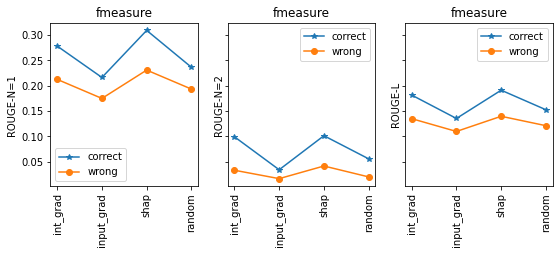

In [13]:
plot_rouge(text_exp, methods, value = 'fmeasure')

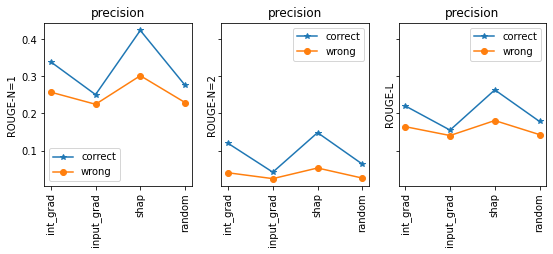

In [14]:
plot_rouge(text_exp, methods, value='precision')

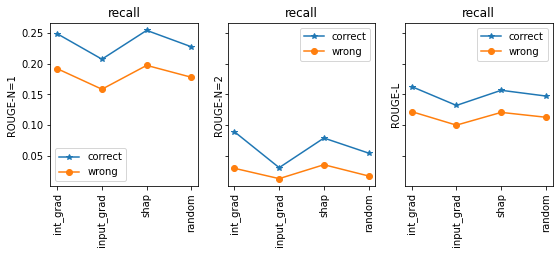

In [15]:
plot_rouge(text_exp, methods, value='recall')